# Incremental mortality modelling

## Read data

In [1]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'sepsis_micro'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

dataQuery = """select * from sepsis_micro.data_matrix_qc_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [36]:
dropCols = [
    'micro_specimen_id',
    'person_id',
    'seven_day_mortality',
    'fourteen_day_mortality',
    'twentyone_day_mortality',
    'twentyeight_day_mortality',
    'sixty_day_mortality',
    'ninety_day_mortality',
    'onetwenty_day_mortality',
    'Ambulatory Clinic / Center',
    'Ambulatory Surgical Center',
    'Emergency Room - Hospital',
    'Emergency Room and Inpatient Visit',
    'Inpatient Visit',
    'Observation Room',
    'AMBULATORY OBSERVATION',
    'DIRECT EMER.',
    'ELECTIVE',
    'EU OBSERVATION',
    'EW EMER.',
    'OBSERVATION ADMIT',
    'SURGICAL SAME DAY ADMISSION',
    'URGENT',
    'AMBULATORY SURGERY TRANSFER',
    'CLINIC REFERRAL',
    'EMERGENCY ROOM',
    'INFORMATION NOT AVAILABLE',
    'INTERNAL TRANSFER TO OR FROM PSYCH',
    'PACU',
    'PHYSICIAN REFERRAL',
    'PROCEDURE SITE',
    'TRANSFER FROM HOSPITAL',
    'TRANSFER FROM SKILLED NURSING FACILITY',
    'WALK-IN/SELF REFERRAL',
]

X = dataDf.drop(dropCols, axis = 1)
y_seven_day = dataDf['seven_day_mortality']
y_fourteen_day = dataDf['fourteen_day_mortality']
y_twentyone_day = dataDf['twentyone_day_mortality']
y_twentyeight_day = dataDf['twentyeight_day_mortality']
y_sixty_day = dataDf['sixty_day_mortality']
y_ninety_day = dataDf['ninety_day_mortality']
y_onetwenty_day = dataDf['onetwenty_day_mortality']

In [112]:
length = len(X)
y_seven_fourteen_day = [(1 if (y_seven_day[i] == 0 and y_fourteen_day[i] == 1) else 0) for i in range(length)]
y_fourteen_twentyone_day = [(1 if (y_fourteen_day[i] == 0 and y_twentyone_day[i] == 1) else 0) for i in range(length)]
y_twentyone_twentyeight_day = [(1 if (y_twentyone_day[i] == 0 and y_twentyeight_day[i] == 1) else 0) for i in range(length)]
y_twentyeight_sixty_day = [(1 if (y_twentyeight_day[i] == 0 and y_sixty_day[i] == 1) else 0) for i in range(length)]
y_sixty_ninety_day = [(1 if (y_sixty_day[i] == 0 and y_ninety_day[i] == 1) else 0) for i in range(length)]
y_ninety_onetwenty_day = [(1 if (y_ninety_day[i] == 0 and y_onetwenty_day[i] == 1) else 0) for i in range(length)]
y_sixty_onetwenty_day = [(1 if ((y_sixty_day[i] == 0 and y_ninety_day[i] == 1) or (y_ninety_day[i] == 0 and y_onetwenty_day[i] == 1)) else 0) for i in range(length)]

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_seven_fourteen_day_train, y_seven_fourteen_day_test = train_test_split(y_seven_fourteen_day, test_size=0.2, random_state=42)
y_fourteen_twentyone_day_train, y_fourteen_twentyone_day_test = train_test_split(y_fourteen_twentyone_day, test_size=0.2, random_state=42)
y_twentyone_twentyeight_day_train, y_twentyone_twentyeight_day_test = train_test_split(y_twentyone_twentyeight_day, test_size=0.2, random_state=42)
y_twentyeight_sixty_day_train, y_twentyeight_sixty_day_test = train_test_split(y_twentyeight_sixty_day, test_size=0.2, random_state=42)
y_sixty_ninety_day_train, y_sixty_ninety_day_test = train_test_split(y_sixty_ninety_day, test_size=0.2, random_state=42)
y_ninety_onetwenty_day_train, y_ninety_onetwenty_day_test = train_test_split(y_ninety_onetwenty_day, test_size=0.2, random_state=42)
y_sixty_onetwenty_day_train, y_sixty_onetwenty_day_test = train_test_split(y_sixty_onetwenty_day, test_size=0.2, random_state=42)

## Function to plot confusion matrix

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.title(title)
    plt.show()

## Function to calculate MCCF1 metric

In [6]:
import sys
import os

from sklearn.metrics import make_scorer

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# import R's "base" package
mccf1 = importr('mccf1')


def calculateMccF1(x, y):
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    p = robjects.FloatVector(x)
    t = robjects.FloatVector(y)
    calculateMccf1 = robjects.r['mccf1']
    summary = robjects.r['summary']
    out = summary(calculateMccf1(t, p), 50)[0][0]
    sys.stdout = old_stdout # reset old stdout
    return out

## Seven to Fourteen day mortality classifier

In [7]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [8]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_seven_fourteen_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

[12:13:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'max_depth': 6, 'scale_pos_weight': 0.3}

### XGBoost model with all features

In [9]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_seven_fourteen_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

[12:14:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Confusion matrix

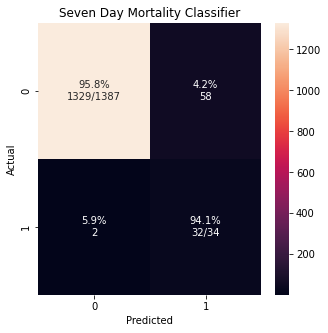

In [10]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_seven_fourteen_day_test, labels, ymap=None, figsize=(5, 5), title='Seven Day Mortality Classifier')

#### Cross validation

In [11]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_seven_fourteen_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_seven_fourteen_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

[12:14:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([0.68265557, 0.66982675, 0.68117762, 0.68285751, 0.67120934]),
 'score_time': array([0.02253318, 0.02130008, 0.02149439, 0.02047658, 0.02165389]),
 'test_accuracy': array([0.96394019, 0.96478873, 0.97447183, 0.9665493 , 0.96390845]),
 'test_balanced_accuracy': array([0.68703402, 0.69001021, 0.77731179, 0.71335375, 0.6796875 ]),
 'test_average_precision': array([0.69662528, 0.63546521, 0.74537829, 0.61083198, 0.61566195]),
 'test_f1': array([0.53932584, 0.54545455, 0.70707071, 0.58695652, 0.52873563]),
 'test_roc_auc': array([0.92336032, 0.87214308, 0.93076821, 0.90096007, 0.87029209]),
 'test_mccf1_score': array([0.64315745, 0.64782611, 0.77112921, 0.67839622, 0.63636737])}

### Feature Importance

<BarContainer object of 131 artists>

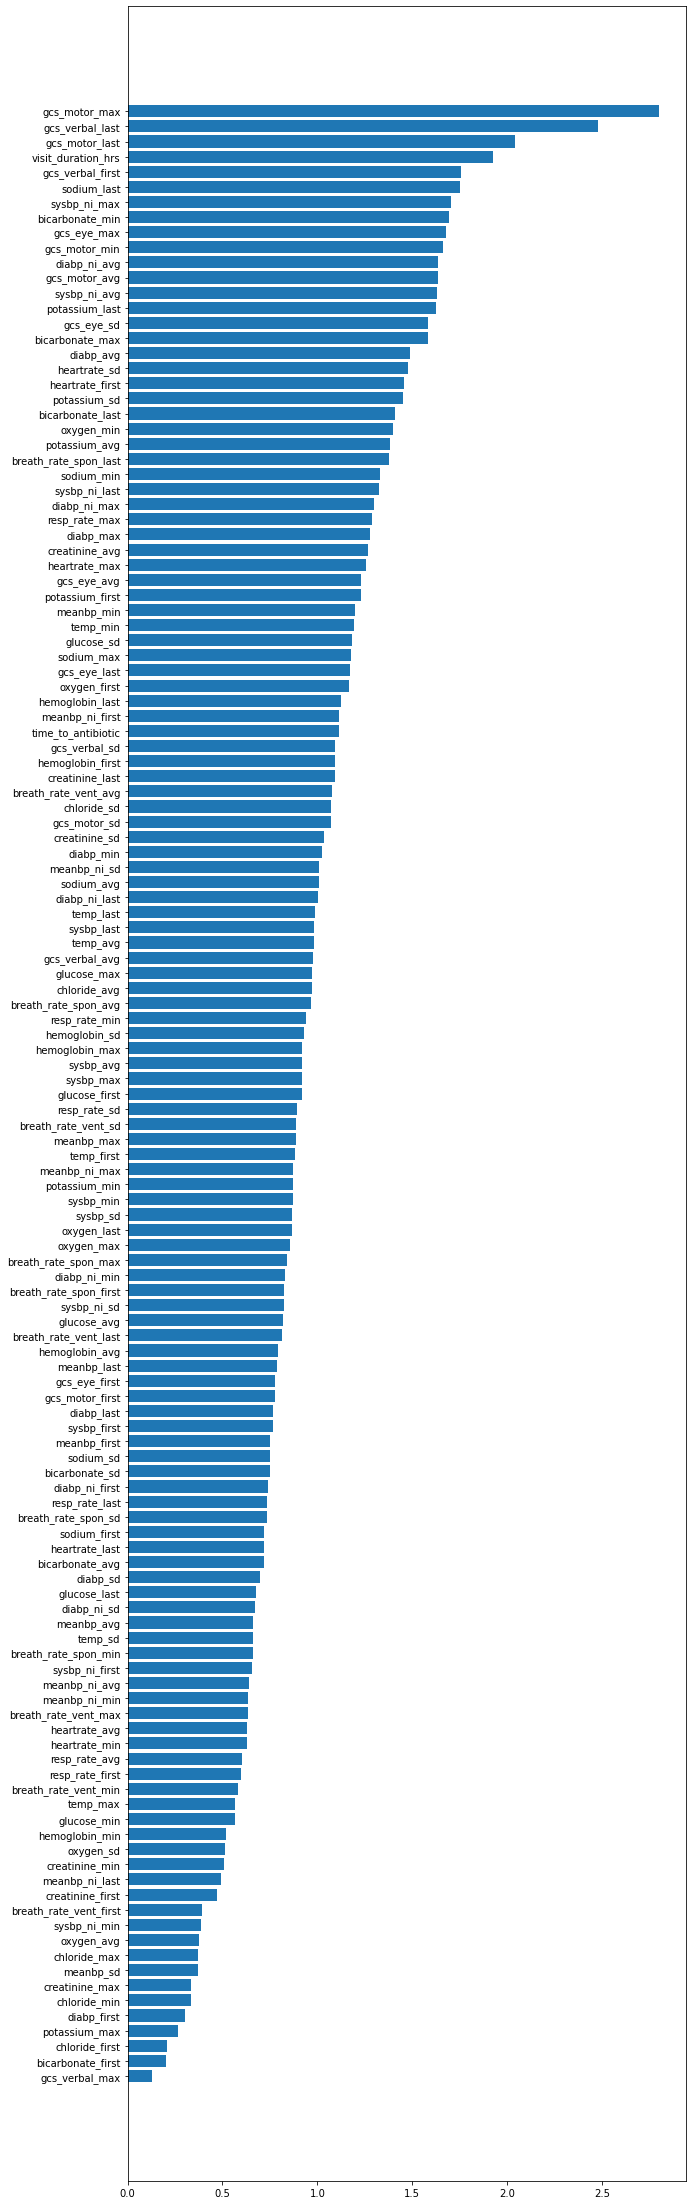

In [13]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Fourteen to Twentyone day mortality classifier

In [73]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [74]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_fourteen_twentyone_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

[12:46:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'max_depth': 9, 'scale_pos_weight': 0.25}

### XGBoost model with all features

In [77]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_fourteen_twentyone_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

[12:50:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Confusion matrix

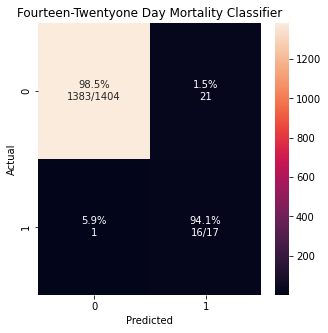

In [79]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_fourteen_twentyone_day_test, labels, ymap=None, figsize=(5, 5), title='Fourteen-Twentyone Day Mortality Classifier')

#### Cross validation

In [80]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_fourteen_twentyone_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_fourteen_twentyone_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

[12:51:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'fit_time': array([0.62257648, 0.62087345, 0.61958289, 0.62057924, 0.6231463 ]),
 'score_time': array([0.0215323 , 0.02152634, 0.02166986, 0.02121711, 0.02115154]),
 'test_accuracy': array([0.98416887, 0.98591549, 0.97887324, 0.98591549, 0.98503521]),
 'test_balanced_accuracy': array([0.70967742, 0.74193548, 0.61290323, 0.74193548, 0.72580645]),
 'test_average_precision': array([0.65777844, 0.6973031 , 0.42653232, 0.56527118, 0.59895542]),
 'test_f1': array([0.59090909, 0.65217391, 0.36842105, 0.65217391, 0.62222222]),
 'test_roc_auc': array([0.86630111, 0.90830536, 0.86720187, 0.82455116, 0.87263173]),
 'test_mccf1_score': array([0.68430222, 0.7308244 , 0.51570309, 0.7308244 , 0.70806412])}

### Feature Importance

<BarContainer object of 133 artists>

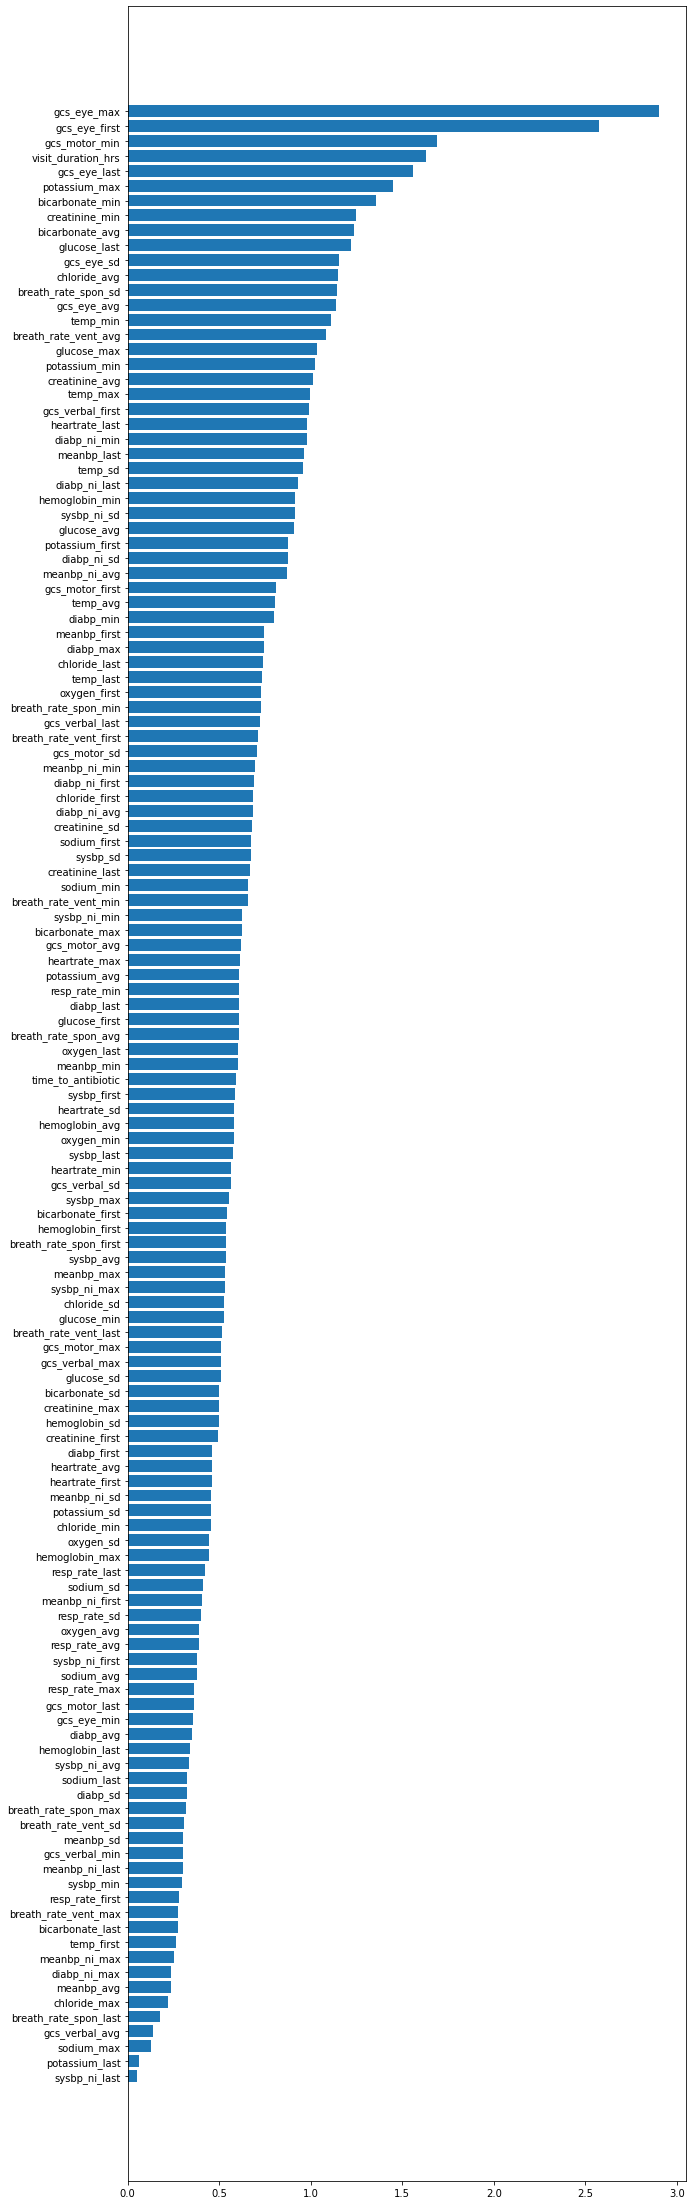

In [81]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Twentyone to Twentyeight day mortality classifier

In [85]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [86]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_twentyone_twentyeight_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

[12:56:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:56:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'max_depth': 9, 'scale_pos_weight': 0.25}

### XGBoost model with all features

In [88]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_twentyone_twentyeight_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

[12:58:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Confusion matrix

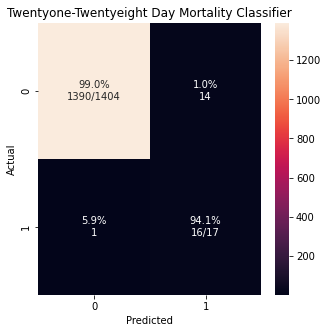

In [91]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_twentyone_twentyeight_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyone-Twentyeight Day Mortality Classifier')

#### Cross validation

In [92]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_twentyone_twentyeight_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_twentyone_twentyeight_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

[12:58:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:58:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

R[write to console]: Error in ROCR::prediction(predictor, response) : 
  Number of classes is not equal to 2.
ROCR currently supports only evaluation of binary classification tasks.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/supe

{'fit_time': array([0.53079057, 0.53233027, 0.62461996, 0.61212111, 0.52789521]),
 'score_time': array([0.02178335, 0.02159905, 0.02074647, 0.02130103, 0.02090836]),
 'test_accuracy': array([0.98944591, 0.98855634, 0.98767606, 0.98943662, 0.98503521]),
 'test_balanced_accuracy': array([0.66666667, 0.61764706, 0.58823529, 0.64705882, 0.5       ]),
 'test_average_precision': array([0.56651067, 0.45918427, 0.39070584, 0.46128011, 0.30984193]),
 'test_f1': array([0.5       , 0.38095238, 0.3       , 0.45454545, 0.        ]),
 'test_roc_auc': array([0.88675405, 0.83540977, 0.9081638 , 0.86295537, 0.86285023]),
 'test_mccf1_score': array([0.61574127, 0.52553767, 0.46388797, 0.5813419 ,        nan])}

### Feature Importance

<BarContainer object of 126 artists>

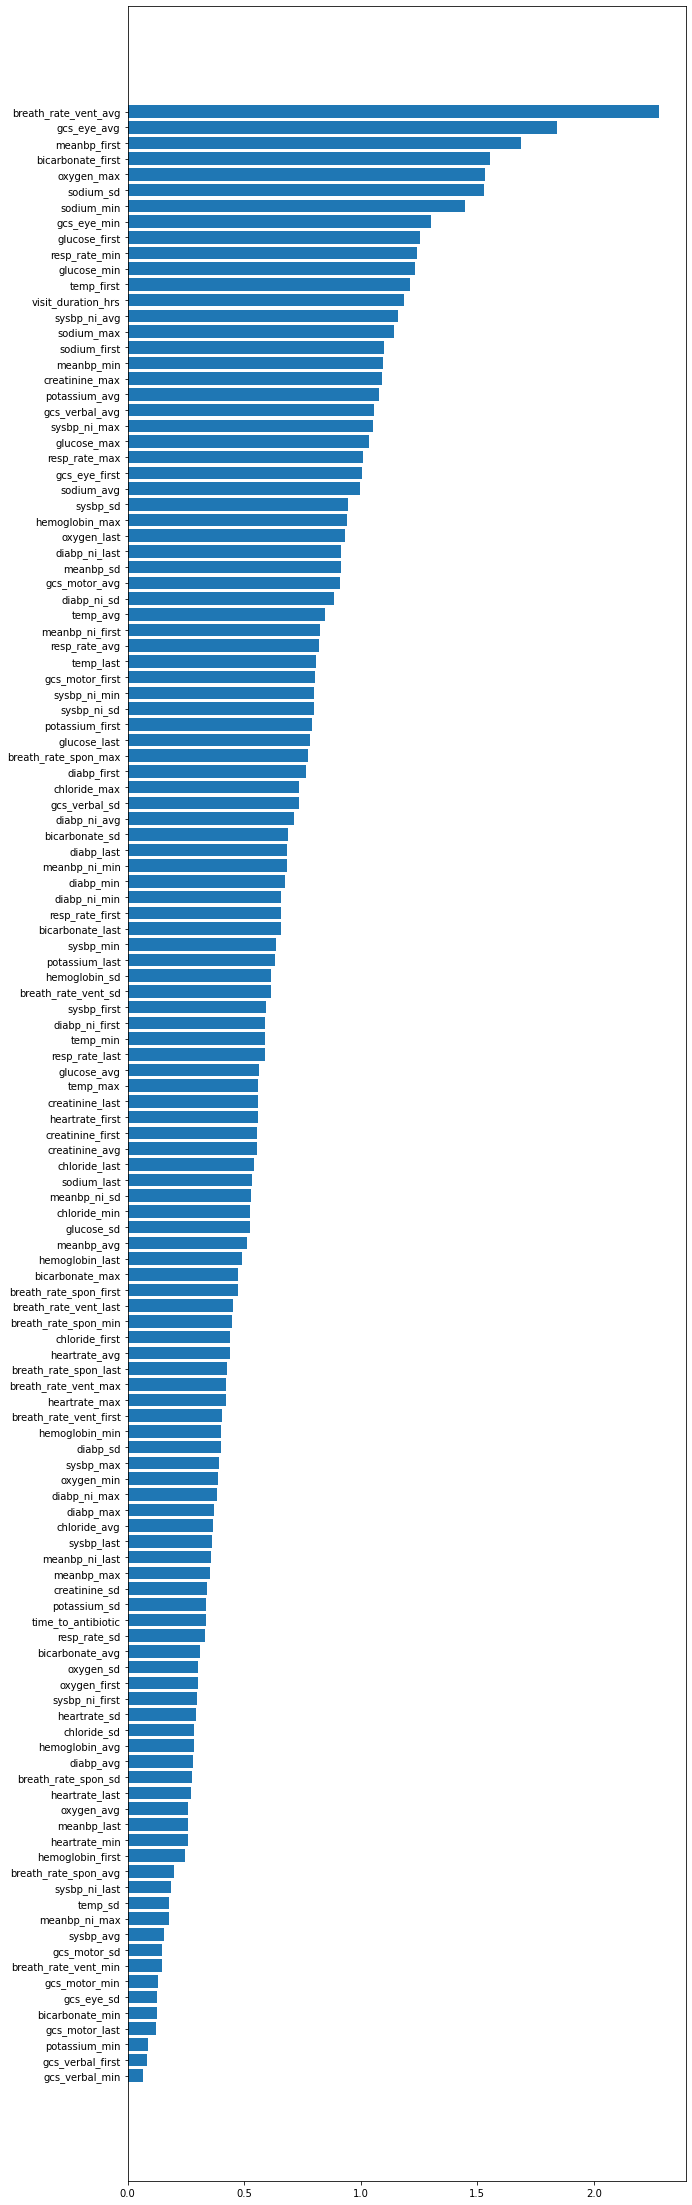

In [93]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Twentyeight to Sixty day mortality classifier

In [94]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [95]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_twentyeight_sixty_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

{'max_depth': 12, 'scale_pos_weight': 0.3}

### XGBoost model with all features

In [96]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_twentyeight_sixty_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

#### Confusion matrix

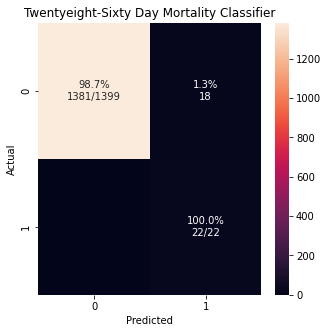

In [97]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_twentyeight_sixty_day_test, labels, ymap=None, figsize=(5, 5), title='Twentyeight-Sixty Day Mortality Classifier')

#### Cross validation

In [98]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_twentyeight_sixty_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_twentyeight_sixty_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

{'fit_time': array([0.60750985, 0.60362792, 0.60301352, 0.61366677, 0.63076878]),
 'score_time': array([0.02070117, 0.02061772, 0.02056432, 0.02070594, 0.02087879]),
 'test_accuracy': array([0.98416887, 0.98503521, 0.98327465, 0.98415493, 0.98239437]),
 'test_balanced_accuracy': array([0.68473473, 0.69185724, 0.64814815, 0.66666667, 0.62962963]),
 'test_average_precision': array([0.5654044 , 0.53438369, 0.51280503, 0.57159262, 0.57371271]),
 'test_f1': array([0.52631579, 0.54054054, 0.45714286, 0.5       , 0.41176471]),
 'test_roc_auc': array([0.85258592, 0.80453915, 0.77560699, 0.89677053, 0.92525799]),
 'test_mccf1_score': array([0.63285393, 0.64366037, 0.58307277, 0.61552515, 0.54868807])}

### Feature Importance

<BarContainer object of 127 artists>

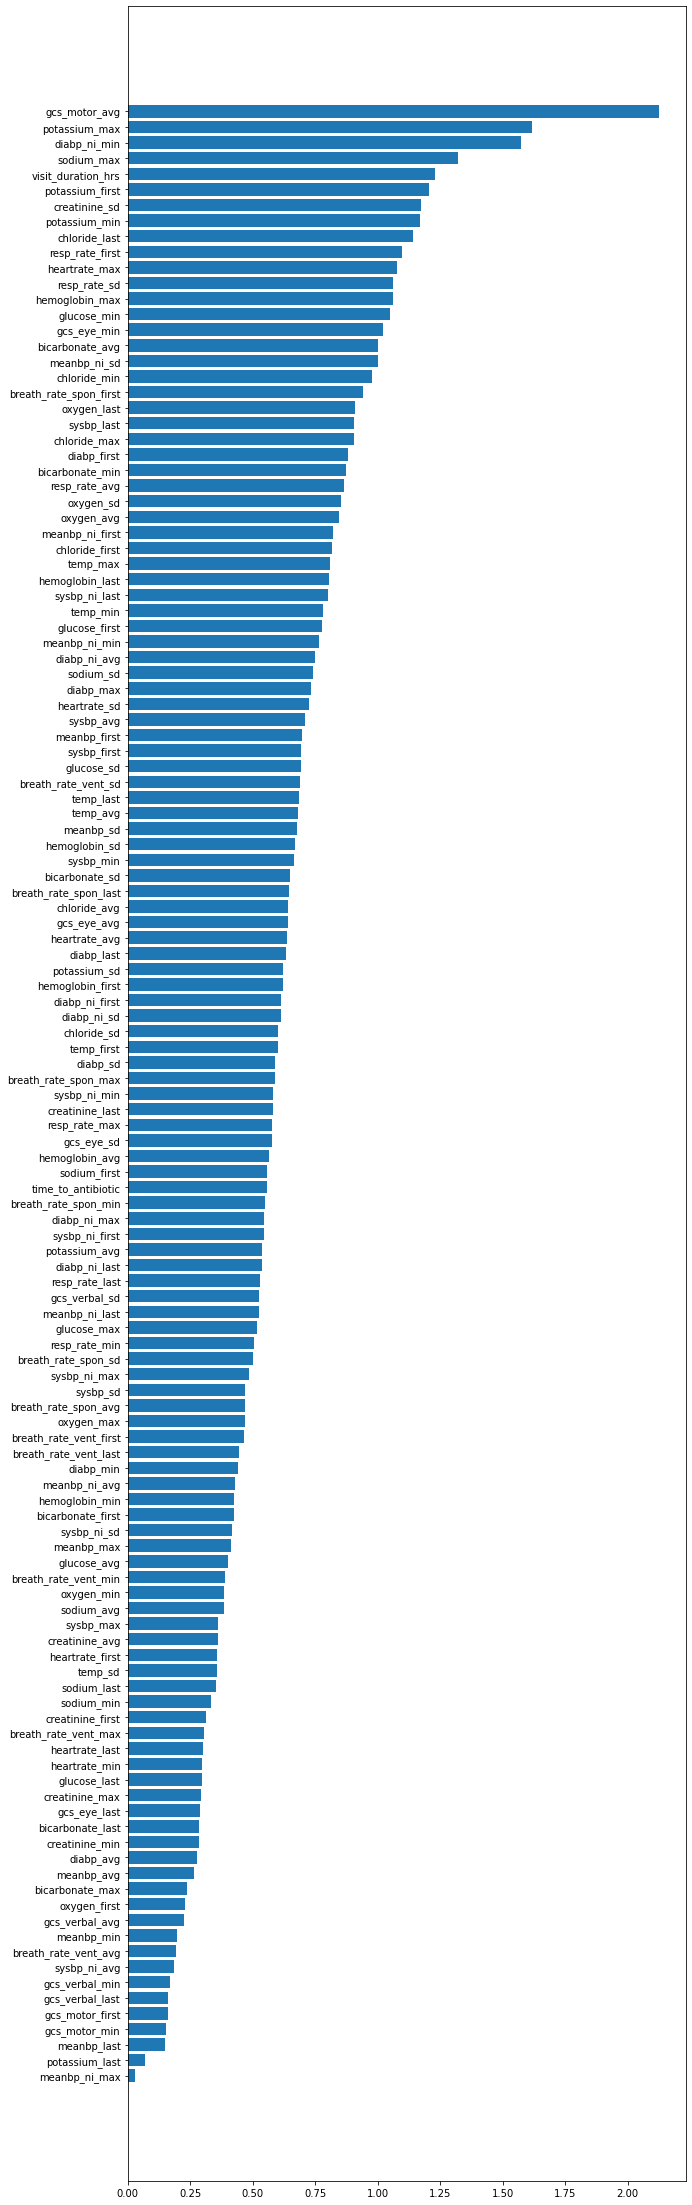

In [99]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Sixty to Ninety day mortality classifier

In [100]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [101]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_sixty_ninety_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

{'max_depth': 6, 'scale_pos_weight': 0.3}

### XGBoost model with all features

In [102]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_sixty_ninety_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

#### Confusion matrix

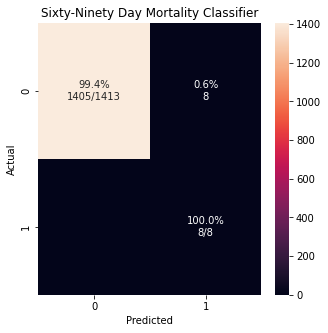

In [103]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_sixty_ninety_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty-Ninety Day Mortality Classifier')

#### Cross validation

In [104]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_sixty_ninety_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_sixty_ninety_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

{'fit_time': array([0.49250865, 0.59726906, 0.4941256 , 0.48408079, 0.49093342]),
 'score_time': array([0.0215826 , 0.02118182, 0.02419782, 0.02074122, 0.02108932]),
 'test_accuracy': array([0.99296394, 0.99207746, 0.99295775, 0.99207746, 0.99119718]),
 'test_balanced_accuracy': array([0.66666667, 0.59090909, 0.63636364, 0.59090909, 0.58333333]),
 'test_average_precision': array([0.41607675, 0.54671361, 0.5265024 , 0.2217641 , 0.29262857]),
 'test_f1': array([0.5       , 0.30769231, 0.42857143, 0.30769231, 0.28571429]),
 'test_roc_auc': array([0.7642963 , 0.86553535, 0.73284848, 0.66610101, 0.71826809]),
 'test_mccf1_score': array([0.61588364, 0.46989117, 0.56180027, 0.46989117, 0.45306253])}

### Feature Importance

<BarContainer object of 116 artists>

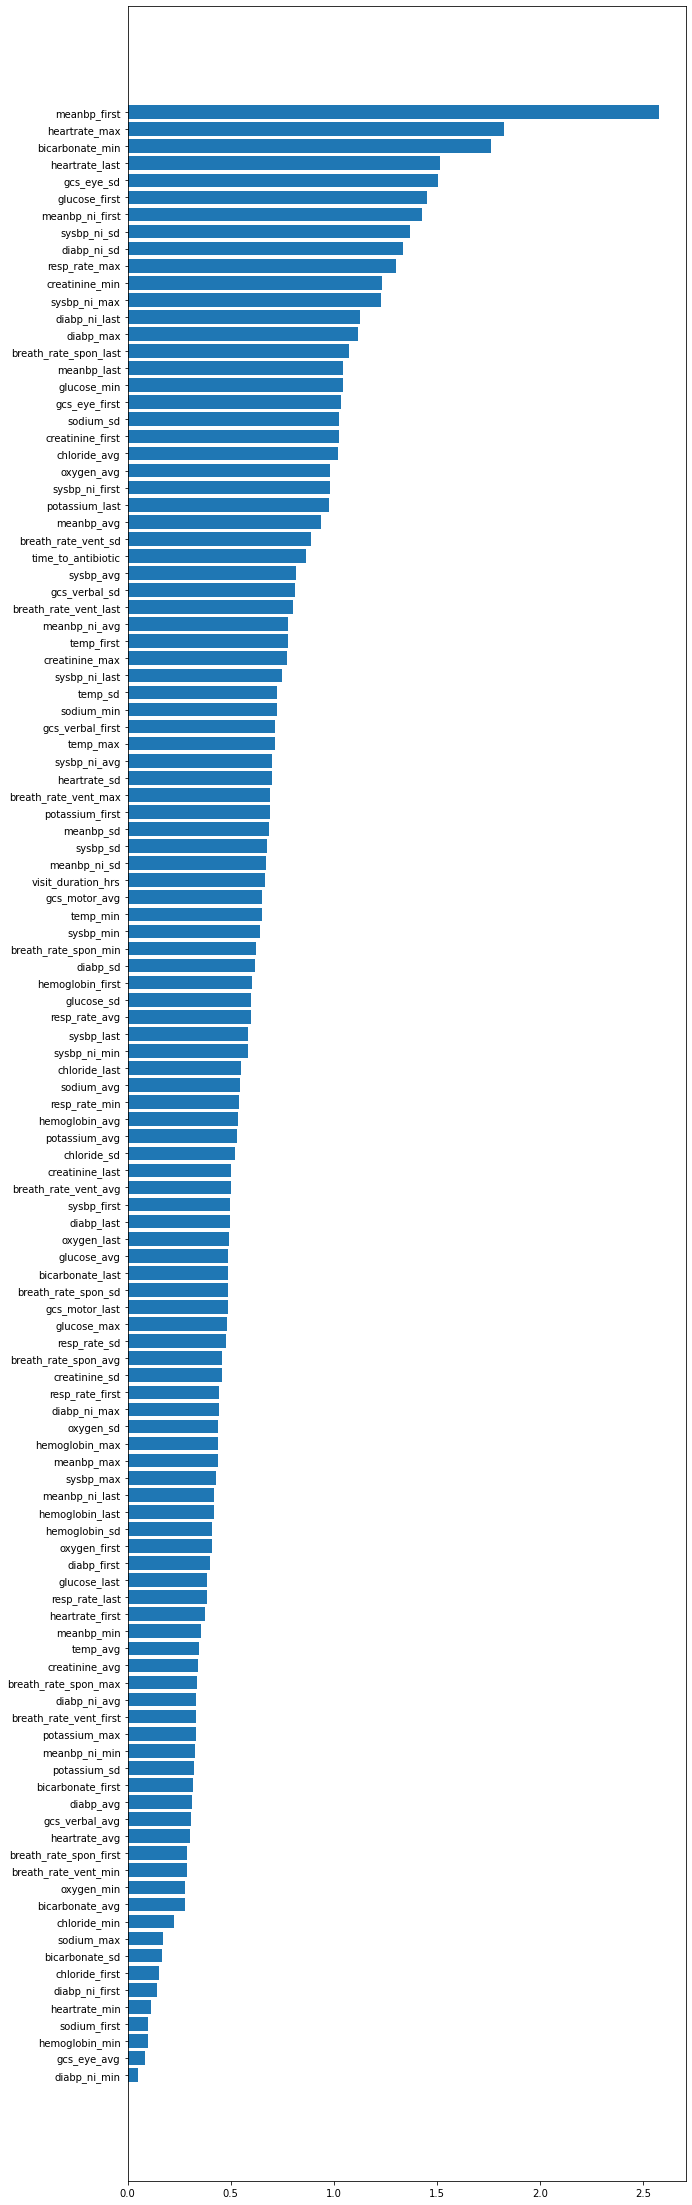

In [105]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Ninety to Onetwenty day mortality classifier

In [106]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [107]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_ninety_onetwenty_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

{'max_depth': 9, 'scale_pos_weight': 0.3}

### XGBoost model with all features

In [108]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_ninety_onetwenty_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

#### Confusion matrix

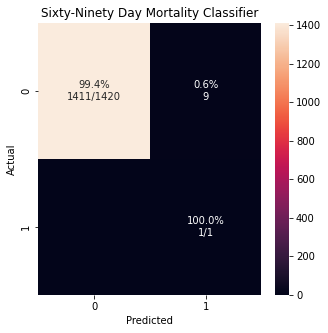

In [109]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_ninety_onetwenty_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty-Ninety Day Mortality Classifier')

#### Cross validation

In [110]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_ninety_onetwenty_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_ninety_onetwenty_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

R[write to console]: Error in ROCR::prediction(predictor, response) : 
  Number of classes is not equal to 2.
ROCR currently supports only evaluation of binary classification tasks.

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    ret

{'fit_time': array([0.4345212 , 0.42829823, 0.44100785, 0.42324448, 0.44131255]),
 'score_time': array([0.02065015, 0.02038813, 0.02058434, 0.046731  , 0.02083993]),
 'test_accuracy': array([0.99648197, 0.99471831, 0.99559859, 0.99647887, 0.99823944]),
 'test_balanced_accuracy': array([0.71428571, 0.5       , 0.58333333, 0.66666667, 0.83333333]),
 'test_average_precision': array([0.62630517, 0.04740616, 0.55709046, 0.40174141, 0.83435478]),
 'test_f1': array([0.6       , 0.        , 0.28571429, 0.5       , 0.8       ]),
 'test_roc_auc': array([0.94209861, 0.58053097, 0.84498525, 0.79483776, 0.85648968]),
 'test_mccf1_score': array([0.6917664 ,        nan, 0.45318506, 0.61602485, 0.84430043])}

### Feature Importance

<BarContainer object of 97 artists>

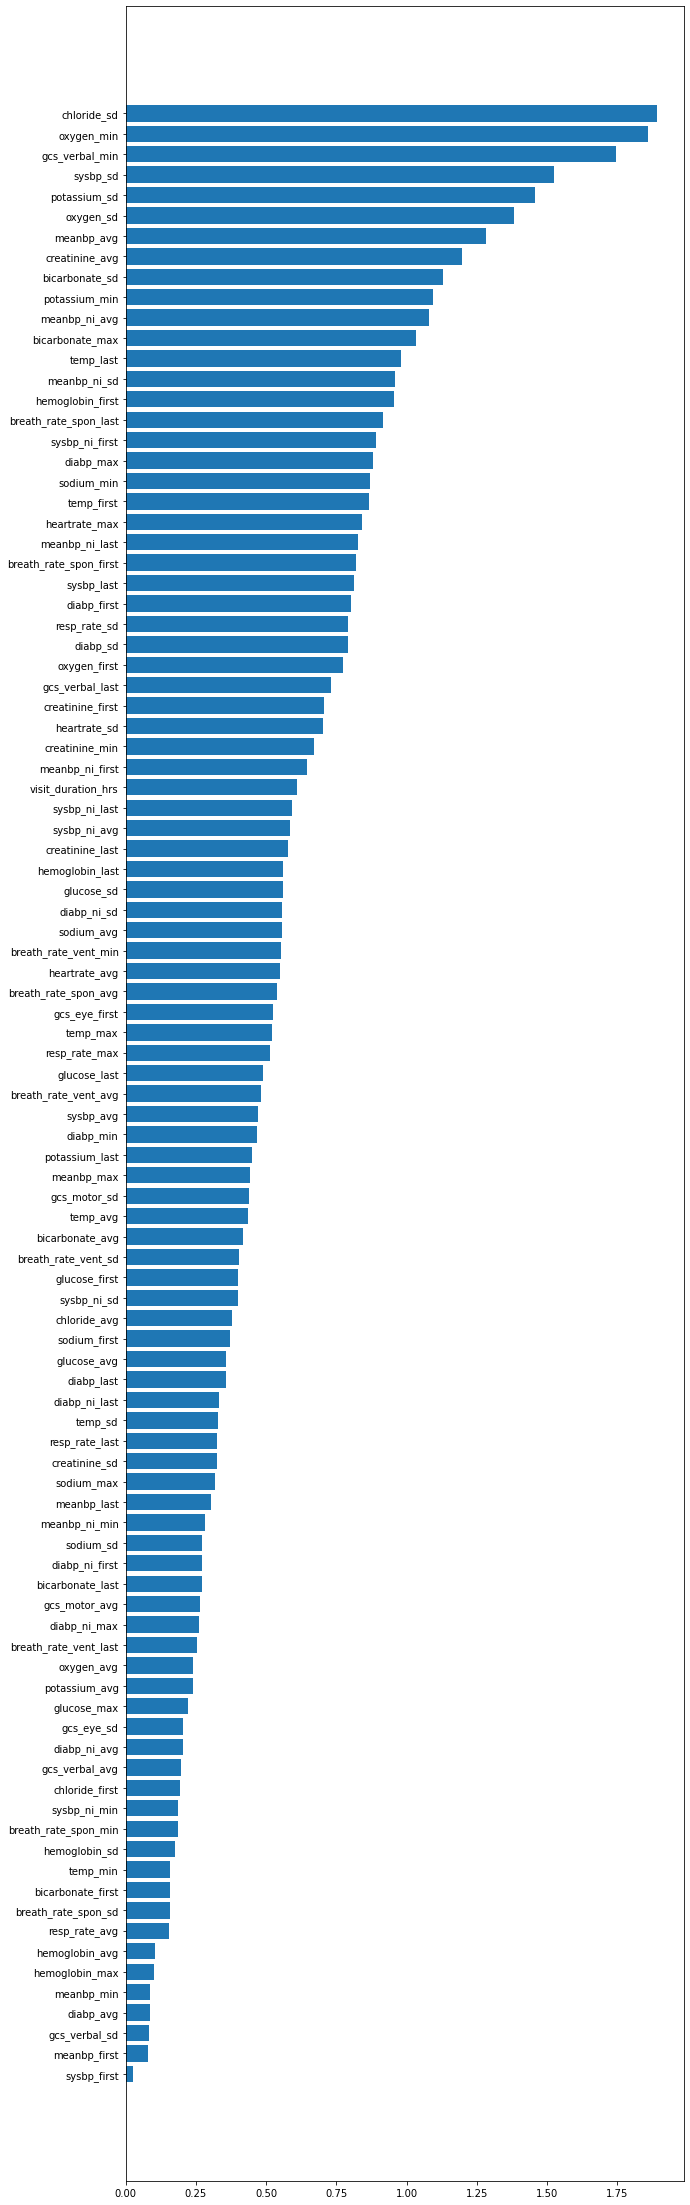

In [111]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)

## Sixty to Onetwenty day mortality classifier

In [106]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Hyperparameter optimisation

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters={
    'max_depth': [6, 9, 12],
    'scale_pos_weight': [0.1, 0.15, 0.2, 0.25, 0.3],
}

clf = GridSearchCV(XGBClassifier(use_label_encoder=False), parameters)
clf.fit(X, y_sixty_onetwenty_day)

params = clf.cv_results_['params'][list(clf.cv_results_['rank_test_score']).index(1)]
params

### XGBoost model with all features

In [ ]:
# xgb = XGBClassifier(max_depth = 12, reg_alpha = 40, max_delta_step=10, scale_pos_weight = 0.25)
xgb = XGBClassifier(use_label_encoder=False)
xgb.set_params(**params)
xgb.fit(X_train, y_sixty_onetwenty_day_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

labels = [0, 1]

cm_analysis(xgb_pred, y_sixty_onetwenty_day_test, labels, ymap=None, figsize=(5, 5), title='Sixty-Onetwenty Day Mortality Classifier')

#### Cross validation

In [ ]:
from sklearn.model_selection import cross_validate

xgb_scores = cross_validate(xgb, X_train, y_sixty_onetwenty_day_train, cv=5, scoring = ['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
xgb_scores['test_mccf1_score'] = cross_validate(xgb, X_train, y_sixty_onetwenty_day_train, cv=5, scoring = make_scorer(calculateMccF1, greater_is_better=True))['test_score']
xgb_scores

### Feature Importance

In [ ]:
X_header = [x for x in X.columns.values]
X_header = X_header[0:-1]
feature_importance_list = []
feature_imp_dict = xgb.get_booster().get_score(importance_type="gain")
for feature, feature_imp in feature_imp_dict.items():
    feature_importance_list.append([feature, feature_imp])
xgbDf = pd.DataFrame(feature_importance_list, columns = ['feature', 'weight'])
xgbDf.sort_values('weight', inplace=True)
plt.figure(figsize=(10,40))
plt.barh(y=xgbDf.feature, width=xgbDf.weight)